# Density vs density-contrast

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

# local python scripts
from RIS_gravity_inversion import plotting
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils
import RIS_gravity_inversion.synthetic as synth

from antarctic_plots import utils, regions, maps, fetch, profile
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import scipy as sp
import rioxarray
import harmonica as hm
import pygmt

PROJ: proj_create_from_database: Cannot find proj.db


In [17]:
rock_prism = [-134, -5, -45, 45, -200, -100]
ice_prism = [-134, -5, -45, 45, -100, 0]
coordinates = [-40, 0, 40]

In [18]:
ice_grav = hm.prism_gravity(coordinates, ice_prism, [917], field="g_z")
ice_grav

array(0.70313092)

In [19]:
rock_grav = hm.prism_gravity(coordinates, rock_prism, [2670], field="g_z")
rock_grav

array(0.54308491)

In [20]:
ice + rock

1.2462158282680684

In [21]:
combined = hm.prism_gravity(
    coordinates, [ice_prism, rock_prism], [917, 2670], field="g_z"
)
combined

array(1.24621583)

In [23]:
ice_contrast = hm.prism_gravity(coordinates, ice_prism, [917 - 2670], field="g_z")
ice_contrast

array(-1.34415321)

In [24]:
ice_contrast = hm.prism_gravity(coordinates, ice_prism, [2670 - 917], field="g_z")
ice_contrast

array(1.34415321)

In [25]:
rock_contrast = hm.prism_gravity(coordinates, rock_prism, [2670 - 917], field="g_z")
rock_contrast

array(0.35656474)

In [26]:
rock_contrast = hm.prism_gravity(coordinates, rock_prism, [917 - 2670], field="g_z")
rock_contrast

array(-0.35656474)

In [61]:
import pygmt
import pyproj
import verde as vd

import harmonica as hm

# Read South Africa topography
south_africa_topo = hm.datasets.fetch_south_africa_topography()

# Project the grid
projection = pyproj.Proj(proj="merc", lat_ts=south_africa_topo.latitude.values.mean())
south_africa_topo = vd.project_grid(south_africa_topo.topography, projection=projection)

print("Min:", np.nanmin(south_africa_topo))
print("Max:", np.nanmax(south_africa_topo))

Min: -4872.0
Max: 3276.1963407124485


In [93]:
# Create layer of water prisms above topography
water_prisms = hm.prism_layer(
    (south_africa_topo.easting, south_africa_topo.northing),
    surface=south_africa_topo,
    reference=4e3,
    properties={"density": 917 * np.ones_like(south_africa_topo)},
)

# Create layer of earth prisms below topography
earth_prisms = hm.prism_layer(
    (south_africa_topo.easting, south_africa_topo.northing),
    surface=south_africa_topo,
    reference=-5e3,
    properties={"density": 2670 * np.ones_like(south_africa_topo)},
)

# Create layer of prisms representing the density contrasts
density_contrast_prisms = hm.prism_layer(
    (south_africa_topo.easting, south_africa_topo.northing),
    surface=south_africa_topo,
    reference=-0,
    properties={"density": (-917 - 2670) * np.ones_like(south_africa_topo)},
)

# Compute gravity field on a regular grid located at 4000m above the ellipsoid
coordinates = vd.grid_coordinates(
    region=(12, 33, -35, -18), spacing=0.2, extra_coords=4000
)
easting, northing = projection(*coordinates[:2])
coordinates_projected = (easting, northing, coordinates[-1])

water_prisms_gravity = water_prisms.prism_layer.gravity(
    coordinates_projected, field="g_z"
)
earth_prisms_gravity = earth_prisms.prism_layer.gravity(
    coordinates_projected, field="g_z"
)

density_contrast_gravity = density_contrast_prisms.prism_layer.gravity(
    coordinates_projected, field="g_z"
)

In [94]:
# turn into xarray dataarrays
water_grav_grid = vd.make_xarray_grid(
    coordinates_projected,
    water_prisms_gravity,
    data_names="gravity",
    extra_coords_names="extra",
)

earth_grav_grid = vd.make_xarray_grid(
    coordinates_projected,
    earth_prisms_gravity,
    data_names="gravity",
    extra_coords_names="extra",
)

density_contrast_grav_grid = vd.make_xarray_grid(
    coordinates_projected,
    density_contrast_gravity,
    data_names="gravity",
    extra_coords_names="extra",
)

# Combine computed gravity
total_gravity = water_grav_grid + earth_grav_grid

In [95]:
# Set figure properties
xy_region = vd.get_region((easting, northing))
w, e, s, n = xy_region
fig_height = 10
fig_width = fig_height * (e - w) / (n - s)
fig_ratio = (n - s) / (fig_height / 100)
fig_proj = f"x1:{fig_ratio}"

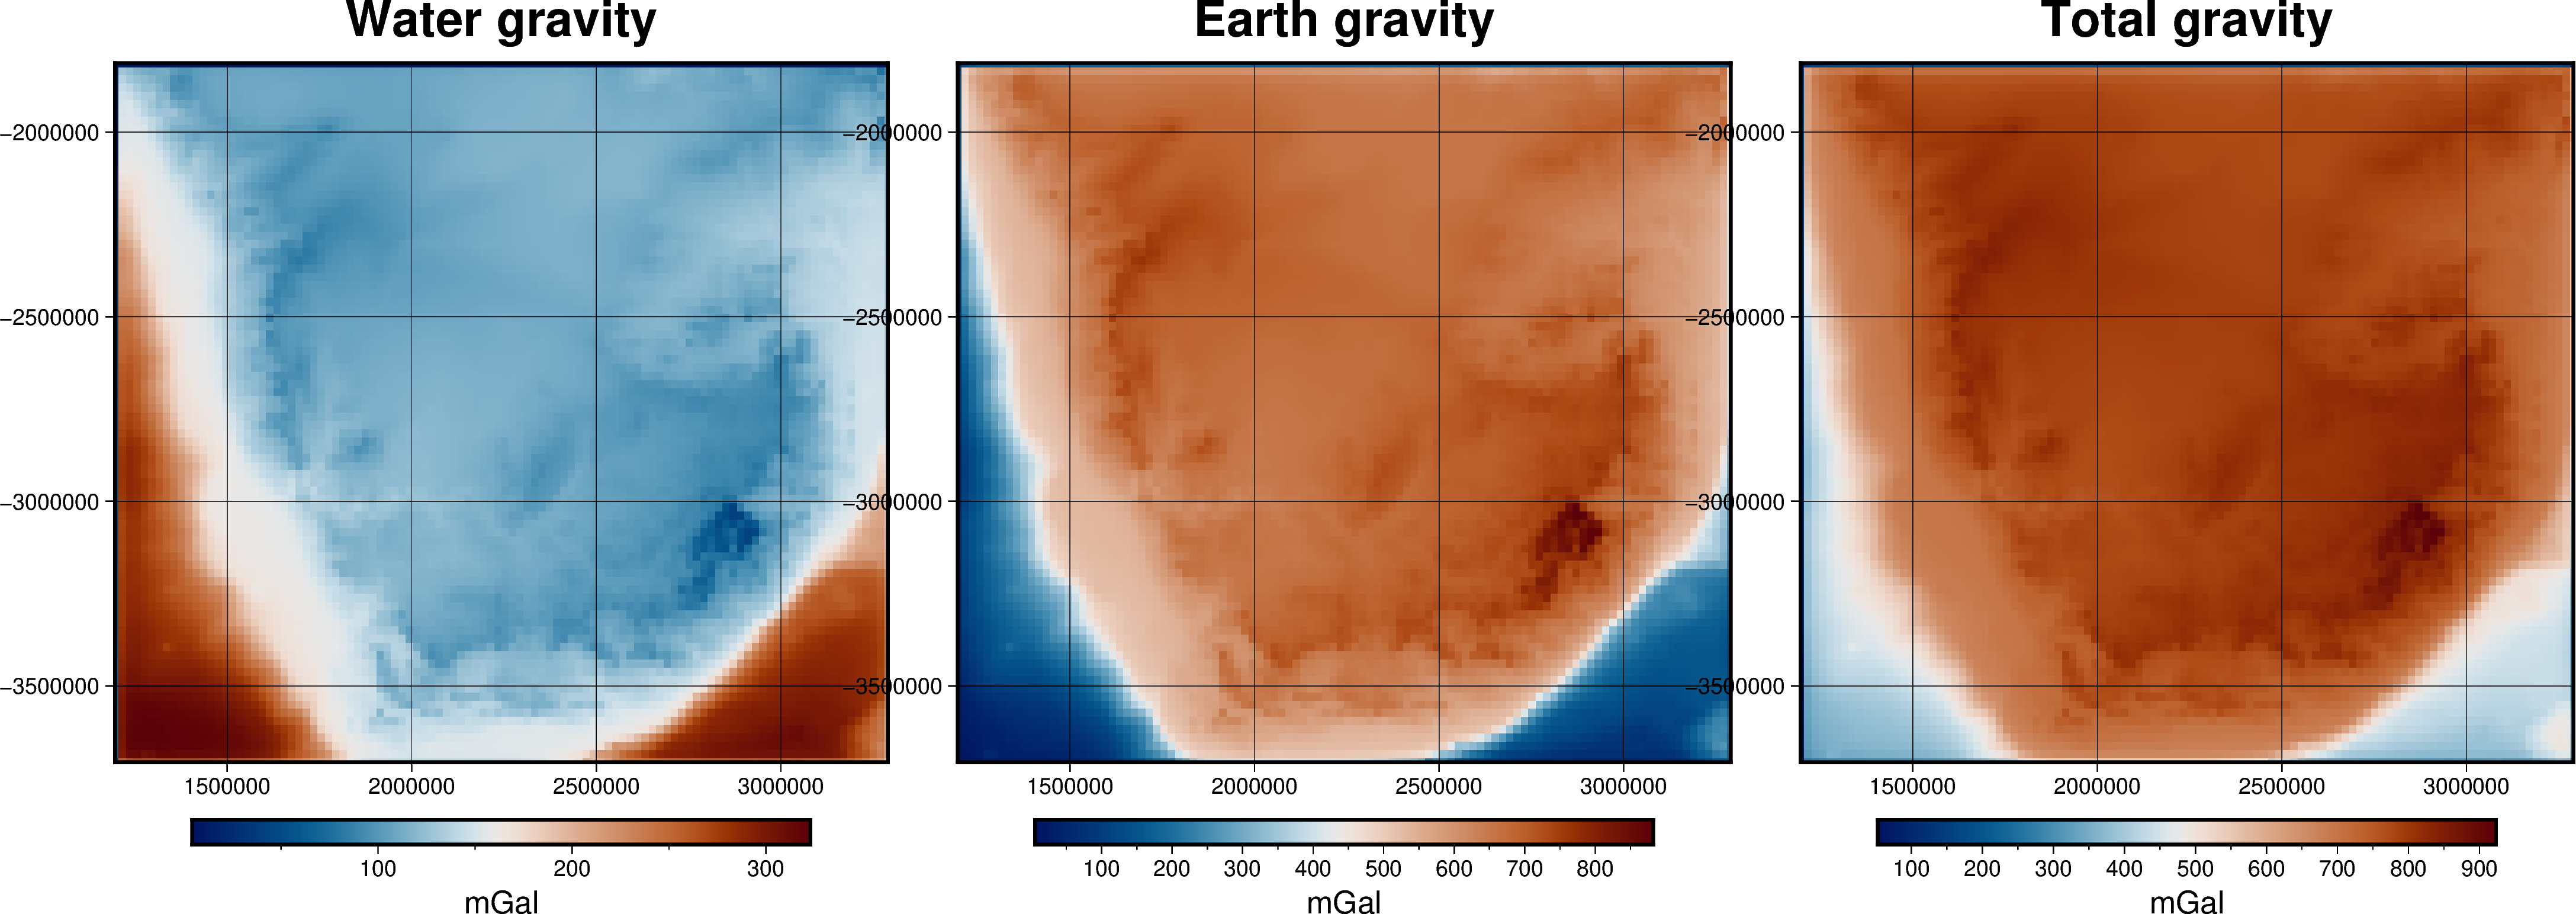

In [96]:
# plot of absolute density gravity
fig = pygmt.Figure()

fig.grdimage(
    region=xy_region,
    projection=fig_proj,
    grid=water_grav_grid.gravity,
    frame=["ag", "+tWater gravity"],
    cmap="vik",
)
fig.colorbar(cmap=True, frame=["a100f50", "x+lmGal"])

fig.shift_origin(xshift=fig_width + 1)

fig.grdimage(
    region=xy_region,
    projection=fig_proj,
    grid=earth_grav_grid.gravity,
    frame=["ag", "+tEarth gravity"],
    cmap="vik",
)
fig.colorbar(cmap=True, frame=["a100f50", "x+lmGal"])

fig.shift_origin(xshift=fig_width + 1)

fig.grdimage(
    region=xy_region,
    projection=fig_proj,
    grid=total_gravity.gravity,
    frame=["ag", "+tTotal gravity"],
    cmap="vik",
)
fig.colorbar(cmap=True, frame=["a100f50", "x+lmGal"])

fig.show()

c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\pygmt\clib\conversion.py:107: RuntimeWarning: Grid may have irregular spacing in the 'northing' dimension, but GMT only supports regular spacing. Calculated regular spacing 22283.15174176384 is assumed in the 'northing' dimension.
  warnings.warn(msg, category=RuntimeWarning)


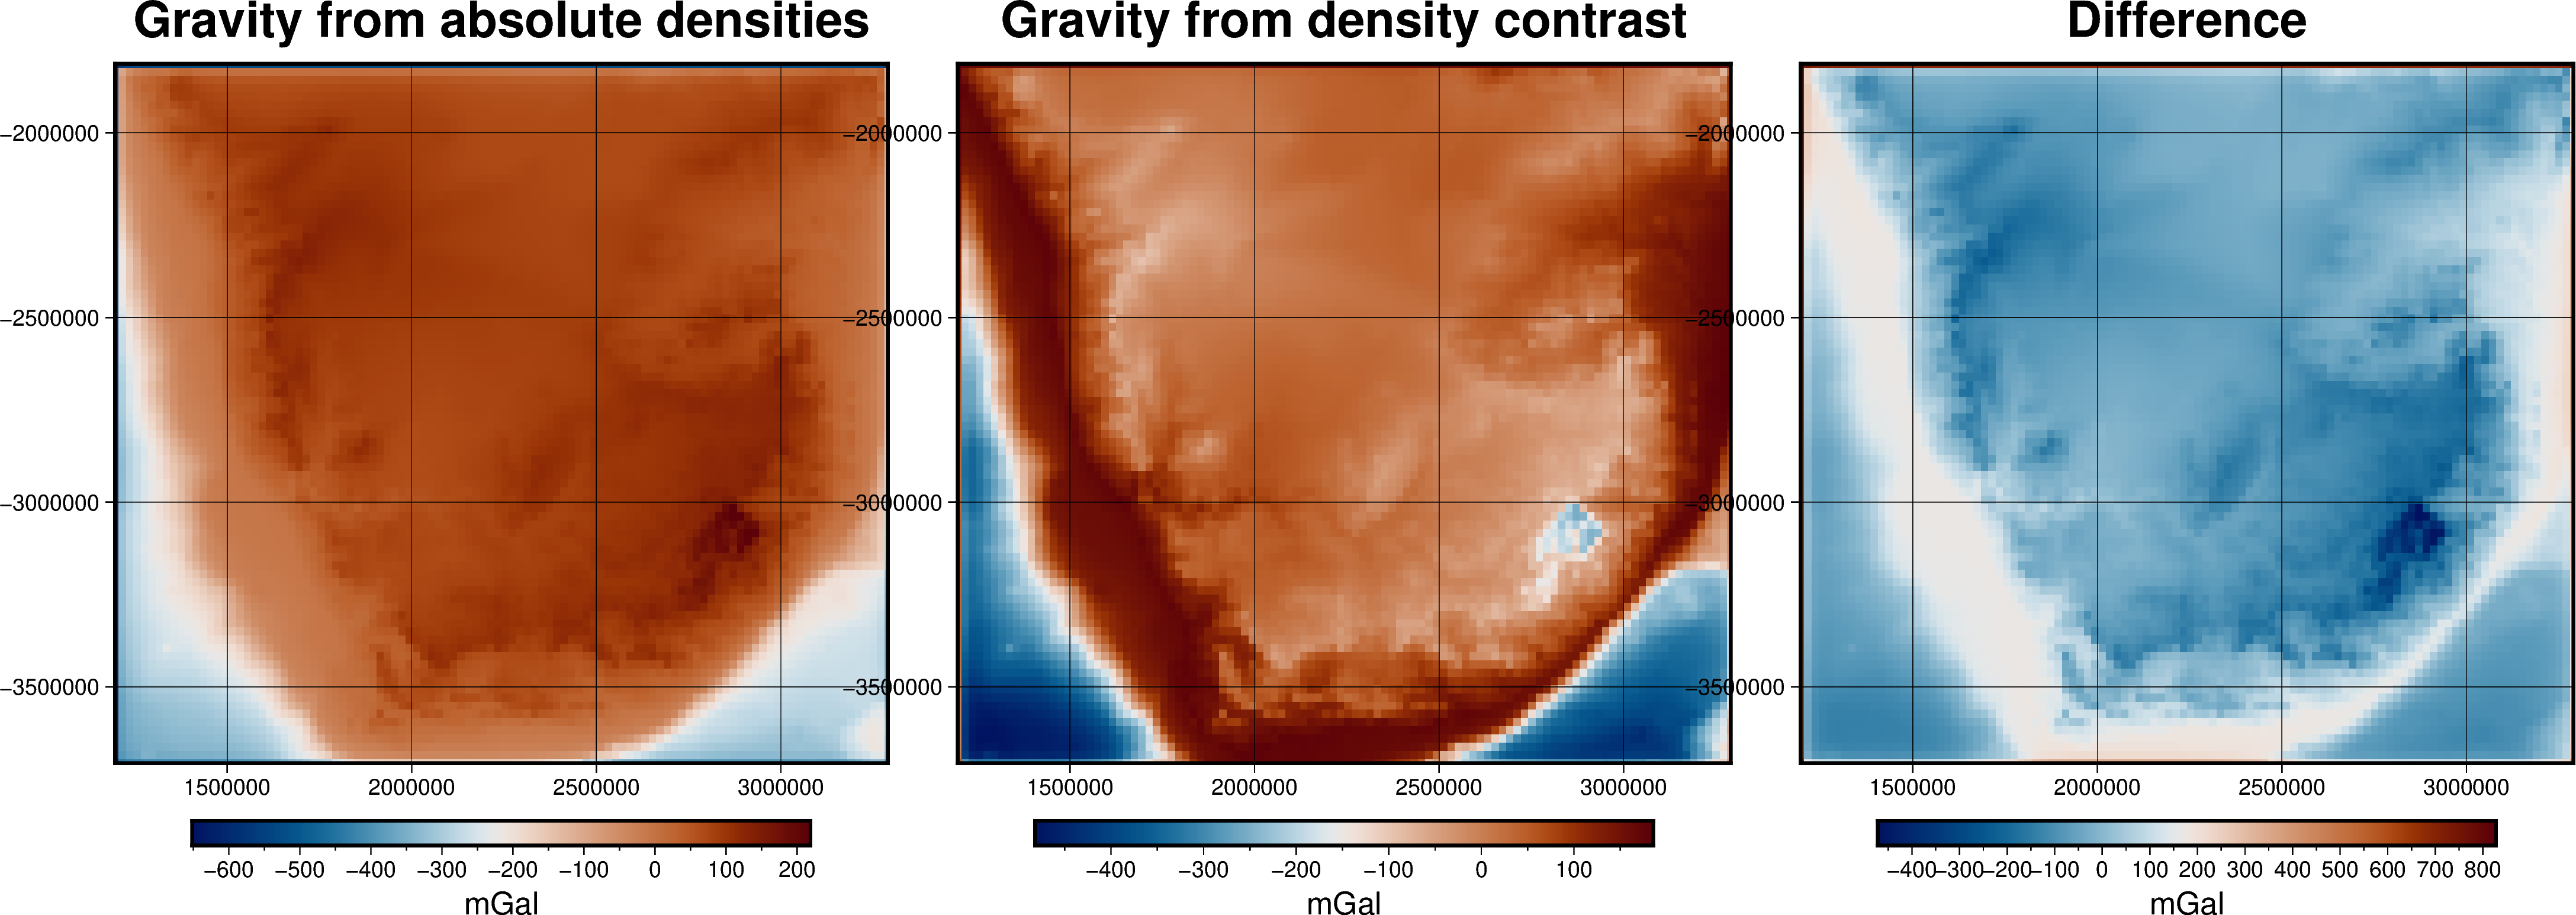

In [97]:
# Center grids on 0
total_gravity -= total_gravity.mean()
density_contrast_grav_grid -= density_contrast_grav_grid.mean()

fig = pygmt.Figure()

fig.grdimage(
    region=xy_region,
    projection=fig_proj,
    grid=total_gravity.gravity,
    frame=["ag", "+tGravity from absolute densities"],
    cmap="vik",
)
fig.colorbar(cmap=True, frame=["a100f50", "x+lmGal"])

fig.shift_origin(xshift=fig_width + 1)

fig.grdimage(
    region=xy_region,
    projection=fig_proj,
    grid=density_contrast_grav_grid.gravity,
    frame=["ag", "+tGravity from density contrast"],
    cmap="vik",
)
fig.colorbar(cmap=True, frame=["a100f50", "x+lmGal"])

fig.shift_origin(xshift=fig_width + 1)

fig.grdimage(
    region=xy_region,
    projection=fig_proj,
    grid=(density_contrast_grav_grid.gravity - total_gravity.gravity),
    frame=["ag", "+tDifference"],
    cmap="vik",
)
fig.colorbar(cmap=True, frame=["a100f50", "x+lmGal"])

fig.show()

(array([  4.,   2.,   0.,   3.,   3.,   3.,   3.,   2.,   4.,   2.,   3.,
          6.,   6.,   2.,   7.,   4.,   5.,  10.,  13.,  24.,  31.,  55.,
        104., 118., 163., 232., 295., 332., 463., 472., 546., 615., 653.,
        674., 660., 366., 251., 186., 183., 159., 176., 124., 133., 152.,
        170., 156., 132., 162., 262., 420., 137.,  61.,  49.,  24.,   9.,
         15.,   6.,   3.,   3.,   9.,   3.,   9.,  31.,  15.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,  14.,  30.,   9.,   4.,
         49.,  63.,   7.,  11.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([-471.76898878, -458.77187107, -445.77475336, -432.77763565,
        -419.78051794, -406.78340023, -393.78628252, -380.78916481,
        -367.79204709, -354.79492938, -341.79781167, -328.80069396,
        -315.80357625, -302.80645854, -289.80934083, -276.81222312,
        -263.81510541, -250.8179877 , -237.820

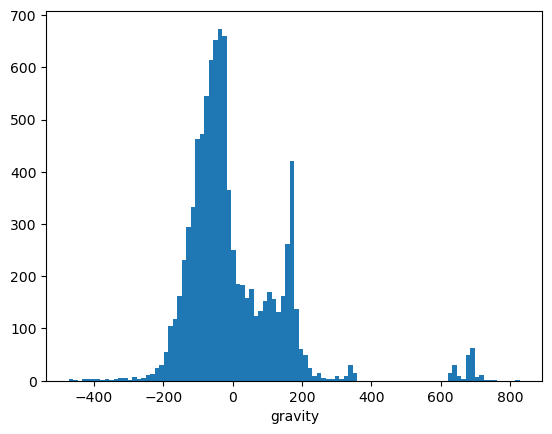

In [100]:
(density_contrast_grav_grid.gravity - total_gravity.gravity).plot.hist(bins=100)